The purpose of this notebook is to explore the relationships between the features in the dataset, then train the XGBoost model. To explore the data, we will employ a heatmap, check the datatypes, and create scatterplots. To build the model, we will try different feature combinations in tandem with GridSarchCV to simultaneously find the optimal hyperparameters. Then, we will export the best model to be used in a Streamlit dashboard.

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import RFE
from xgboost import XGBRegressor  # use XGBClassifier if target is categorical
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df = pd.read_excel("emissions_forecasting_data.xlsx")

We will first check for null values in the dataset. The only null values should be in the lagged columns because prior to this point we performed data cleaning where we checked for and filled missing entries. 

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 49 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   1200 non-null   object 
 1   Year                    1200 non-null   int64  
 2   electricity_sales       1200 non-null   int64  
 3   coal_use                1200 non-null   int64  
 4   natural_gas_use         1200 non-null   int64  
 5   petroleum_use           1200 non-null   int64  
 6   nuclear_use             1200 non-null   int64  
 7   renewables_use          1200 non-null   int64  
 8   biomass_use             1200 non-null   int64  
 9   geothermal_use          1200 non-null   int64  
 10  hydro_use               1200 non-null   int64  
 11  solar_use               1200 non-null   int64  
 12  wind_use                1200 non-null   int64  
 13  residential_use         1200 non-null   int64  
 14  commercial_use          1200 non-null   

In [27]:
df.describe()

,Year,electricity_sales,coal_use,natural_gas_use,petroleum_use,nuclear_use,renewables_use,biomass_use,geothermal_use,hydro_use,...,biomass_use_lag1,geothermal_use_lag1,hydro_use_lag1,solar_use_lag1,wind_use_lag1,real_gdp_lag1,carbon_intensity_lag1,electricity_sales_lag1,total_consumption_lag1,rps_lag2
count,1200.000000,1200.000000,1.200000e+03,1.200000e+03,1.200000e+03,1.200000e+03,1.200000e+03,1200.0000,1200.000000,1200.000000,...,1150.000000,1150.000000,1150.000000,1150.000000,1150.000000,1.150000e+03,1150.000000,1150.000000,1.150000e+03,1099.000000
mean,2011.500000,73676.281667,3.509193e+05,5.324047e+05,7.297423e+05,1.648302e+05,1.185992e+05,82916.3000,2058.900000,18352.144167,...,82282.578261,2044.658261,18423.150435,3975.493043,9945.998261,3.482177e+05,58.540957,73519.273913,1.897928e+06,7.552029
std,6.925073,70325.643327,3.721607e+05,6.993898e+05,9.521013e+05,2.150812e+05,1.191319e+05,74421.9439,6272.258088,42445.698434,...,72963.461890,6281.349865,42700.802176,15638.972682,28873.829389,4.318560e+05,10.553188,69842.464720,2.039030e+06,11.167238
min,2000.000000,5310.000000,0.000000e+00,7.600000e+01,6.700600e+04,0.000000e+00,1.314000e+03,1065.0000,2.000000,0.000000,...,1065.000000,2.000000,0.000000,0.000000,0.000000,2.484460e+04,27.700000,5310.000000,1.126350e+05,0.000000
25%,2005.750000,23843.500000,4.307775e+04,1.729112e+05,2.374822e+05,0.000000e+00,3.864700e+04,23118.0000,244.000000,1944.250000,...,22972.500000,236.250000,1938.750000,45.000000,0.000000,8.121093e+04,50.825000,23754.250000,6.625600e+05,0.000000
50%,2011.500000,56210.500000,2.568930e+05,3.088645e+05,5.011330e+05,9.678150e+04,8.552700e+04,62310.5000,663.000000,5008.000000,...,62183.500000,663.000000,4991.500000,276.500000,590.500000,2.123230e+05,57.300000,56096.000000,1.428990e+06,2.000000
75%,2017.250000,97294.250000,4.727098e+05,6.189595e+05,8.138642e+05,2.952942e+05,1.589058e+05,127660.5000,1320.500000,11995.000000,...,127110.250000,1295.250000,11949.750000,1514.500000,8085.000000,4.361384e+05,65.100000,97402.750000,2.479201e+06,11.290000
max,2023.000000,492820.000000,1.695239e+06,5.284670e+06,6.850873e+06,1.047170e+06,1.065179e+06,612607.0000,46830.000000,313282.000000,...,497652.000000,46830.000000,313282.000000,232908.000000,391653.000000,3.184008e+06,86.300000,475401.000000,1.382988e+07,60.290000


The dataset has 0 NaNs (except for the first year of each state's data for lagged columns) and all features are numeric, except for the state name, which can be excluded from the model as it will lack predictive power

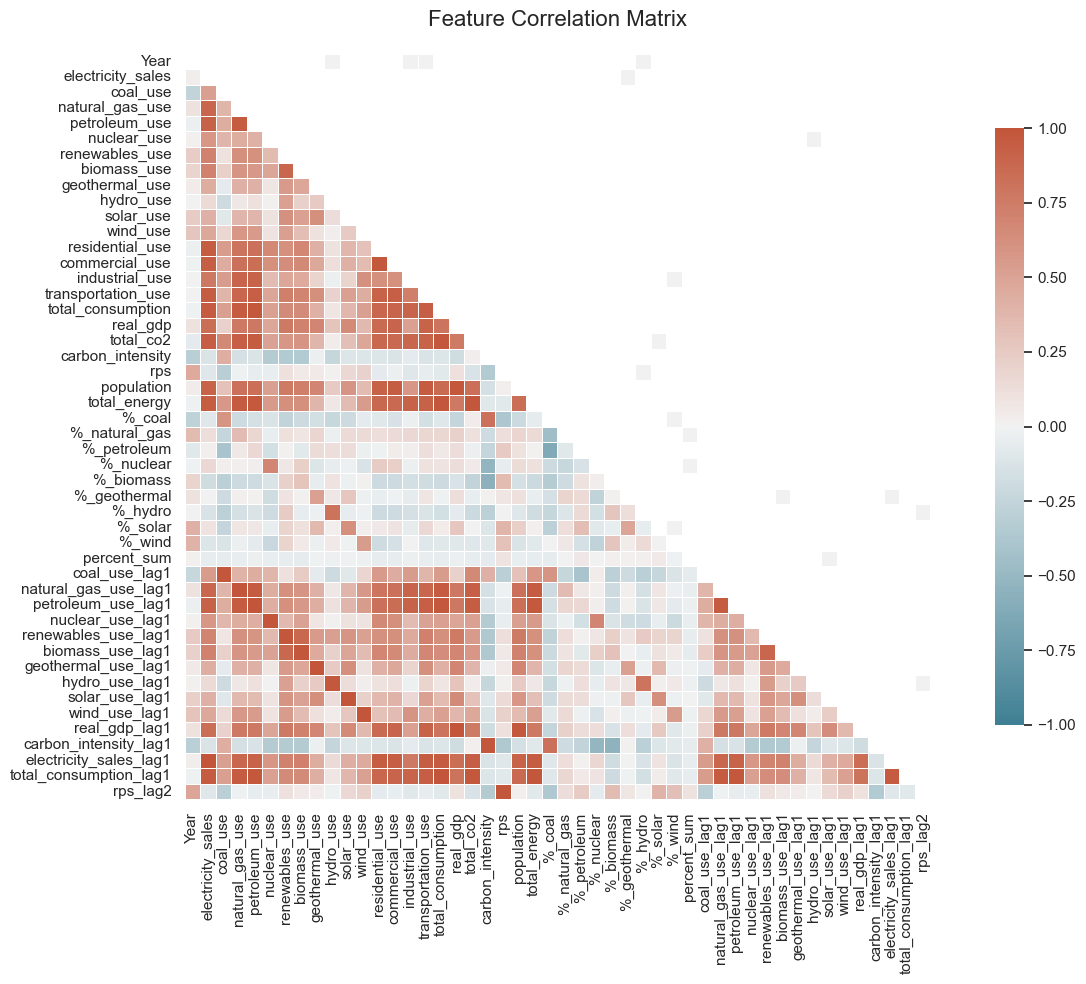

In [28]:
# Correlation 

# Drop rows with missing lagged values (only if necessary)
df_corr = df.dropna()

# Compute correlation matrix (rounded for readability)
corr = df_corr.corr(numeric_only=True).round(2)


plt.figure(figsize=(14, 10))
sns.set_theme(style="white")

# Create a custom diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Mask upper triangle for cleaner look
mask = np.triu(corr)

sns.heatmap(
    corr, 
    mask=mask, 
    cmap=cmap, 
    vmin=-1, vmax=1,
    center=0,
    square=True, 
    annot=False,   # change to True if you want correlation values printed
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title("Feature Correlation Matrix", fontsize=16, pad=20)
plt.tight_layout()
plt.show()


Based on the heatmap, we can see there is a wide range of correlation values. We can sort the feature pairings into groups based on their correlation. Because it is possible for a feature to have a strong non-linear relationship with co2 emissions, we will not use correlation to determine the strongest predictors. This analysis is useful in helping us determine which features are most correlated with one another. We can consider removing highly correlated features, as multi-collinerity increases variance is the predictions without adding additional insights.

In [29]:
# Convert to long format
corr_long = (
    corr.stack()
    .reset_index()
    .rename(columns={'level_0': 'Feature1', 'level_1': 'Feature2', 0: 'Correlation'})
)

# Remove self-correlations and duplicates
corr_long = corr_long[corr_long['Feature1'] < corr_long['Feature2']]


def categorize_corr(value):
    if value >= 0.9:
        return "Strong Pos"
    elif value >= 0.4:
        return "Moderate Pos"
    elif value >= 0.2:
        return "Weak Pos"
    elif value <= -0.7:
        return "Strong Neg"
    elif value <= -0.4:
        return "Moderate Neg"
    elif value <= -0.2:
        return "Weak Neg"
    else:
        return "Uncorrelated"

corr_long['Category'] = corr_long['Correlation'].apply(categorize_corr)


The dataframe below lists all feature pairs that are considered strongly positively correlated (r >= 0.9). We have MANY strong positive correlations. Feature selection may be necessary.

In [30]:
# Columns that are highly positively correlated
corr_long[corr_long['Category'] == 'Strong Pos']

,Feature1,Feature2,Correlation,Category
52,electricity_sales,petroleum_use,0.92,Strong Pos
60,electricity_sales,residential_use,0.95,Strong Pos
63,electricity_sales,transportation_use,0.95,Strong Pos
64,electricity_sales,total_consumption,0.96,Strong Pos
66,electricity_sales,total_co2,0.94,Strong Pos
...,...,...,...,...
2182,electricity_sales_lag1,total_energy,0.95,Strong Pos
2195,electricity_sales_lag1,petroleum_use_lag1,0.91,Strong Pos
2206,electricity_sales_lag1,total_consumption_lag1,0.96,Strong Pos
2223,total_consumption_lag1,transportation_use,0.94,Strong Pos


In [31]:
# Columns that are highly negatively correlated
corr_long[corr_long['Category'] == 'Strong Neg']

,Feature1,Feature2,Correlation,Category


There are no strong negative correlations, but there are 87 / 1600 strong positive correlations. Upon a quick examination, some of these correlations make sense. For instance, we would expect that as energy use (in the form of natural gas or renewables) increases, that electricity sales may also increase, as some of the energy is being used for electricity.

Viewing the relationships between the predictors and the target

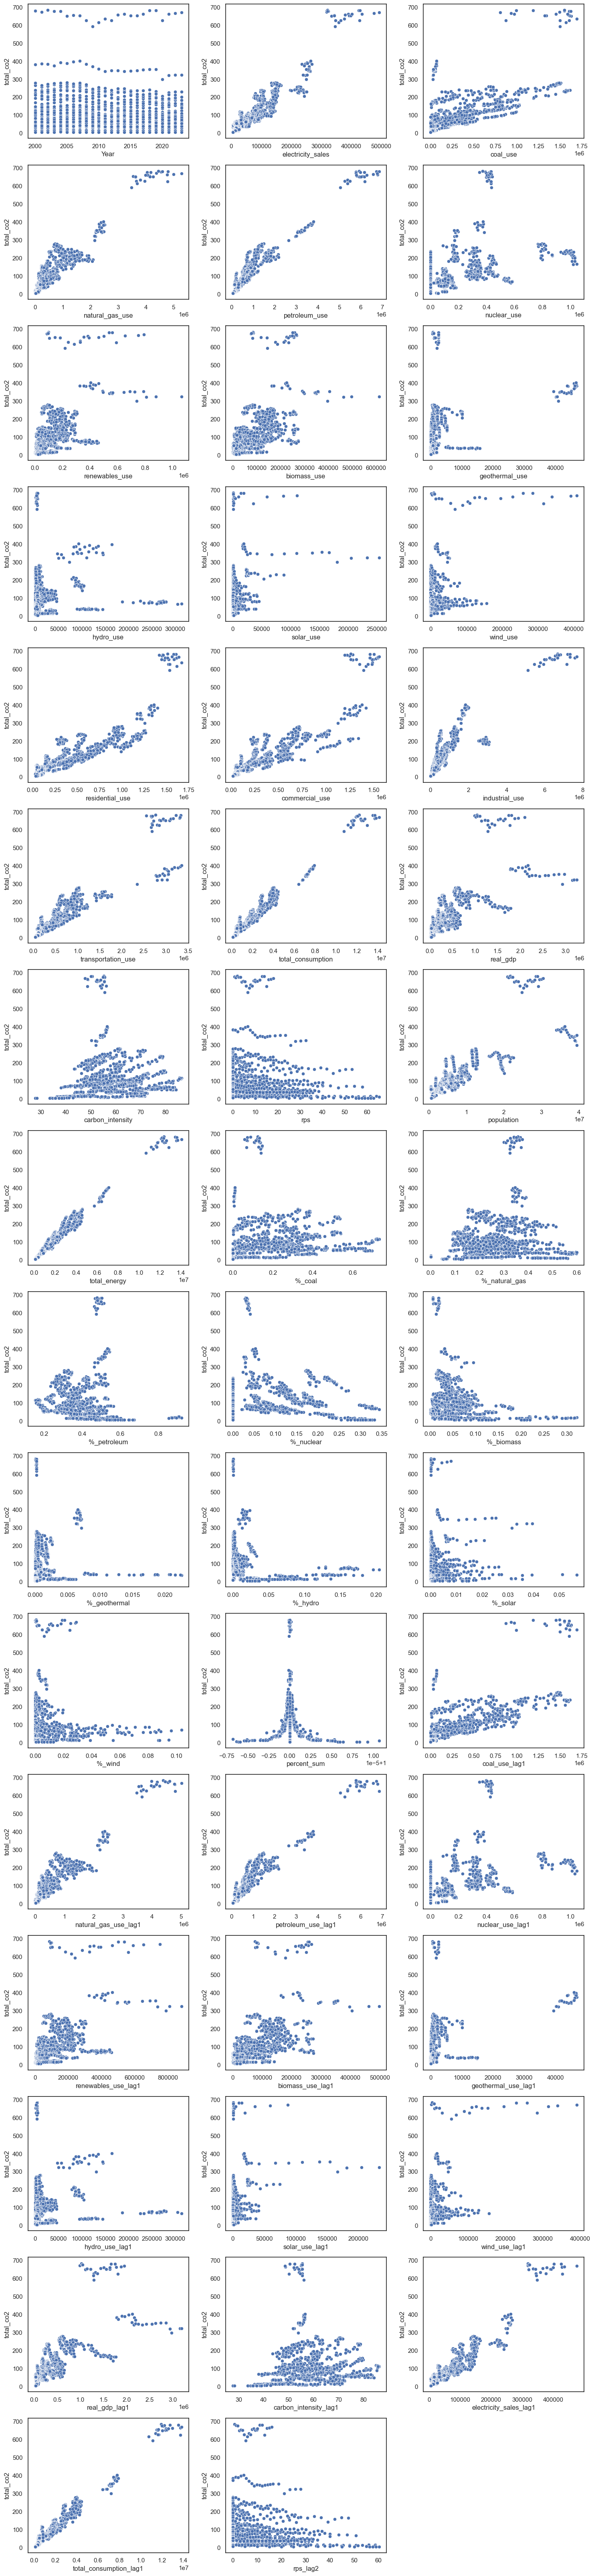

In [46]:
target = 'total_co2'

# Set up figure size
num_features = len(df.columns) - 1  # exclude target
cols = 3  # number of subplots per row
rows = (num_features // cols) + 1

plt.figure(figsize=(5*cols, 4*rows))

# Loop through features
plot_idx = 1
for feature in df.columns:
    if feature == target or feature == 'State':
        continue
    plt.subplot(rows, cols, plot_idx)
    sns.scatterplot(x=df[feature], y=df[target])
    plt.xlabel(feature)
    plt.ylabel(target)
    plot_idx += 1

plt.tight_layout()
plt.show()


### Splitting data and defining function to run GridSearch CV

In [33]:
# Segment into predictors and target data
X = df.drop(['total_co2', 'State'], axis = 'columns')
y = df['total_co2']

# Create train / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 40)

mini_X_train = X_train.drop(["%_coal", "%_natural_gas", "%_petroleum", "%_nuclear", "%_biomass", "%_geothermal", "%_hydro", "%_solar", "%_wind"], axis = 'columns')
mini_X_test = X_test.drop(["%_coal", "%_natural_gas", "%_petroleum", "%_nuclear", "%_biomass", "%_geothermal", "%_hydro", "%_solar", "%_wind"], axis = 'columns')

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],                   # number of trees
    'max_depth': [3, 5, 7],                       # number of splits 
    'learning_rate': [0.01, 0.1, 0.2],            # parameter adjustment sizing
    'subsample': [0.8, 1],                        # fraction of training samples used / tree
    'colsample_bytree': [0.8, 1]                  # fraction of features used / tree
}

# Fit the Grid Search obj
# This performs crosss validation using training set to determine best parameter combo
def perform_grid_search(X_train, y_train):
    grid = GridSearchCV(
        estimator = XGBRegressor(objective='reg:squarederror', random_state=42),   # objective: minimize MSE
        param_grid=param_grid,
        cv=5,                                                                      # 5-fold cross-validation
        scoring='neg_mean_squared_error',                                          # So GridSearchCV always maximizes the score), scikit-learn negates MSE values.
        n_jobs=-1, 
        error_score='raise'
    ).fit(X_train, y_train)
    
    # Obtain best model
    results_df = pd.DataFrame(grid.cv_results_)
    results_df = results_df[
        [
            'params',
            'mean_test_score',
            'std_test_score',
            'rank_test_score'
        ]
    ].sort_values(by='rank_test_score')
    
    
    # Obtain best model
    xgb = grid.best_estimator_
    print('The best parameter combination is', grid.best_params_)
    
    # View grid results
    print('MSE of best GridSearchCV model:', results_df.reset_index().loc[0, 'mean_test_score'])
    return xgb, results_df

### Grid Search CV for all features

In [34]:
xgb1, results_df1 = perform_grid_search(X_train, y_train)
results_df1

The best parameter combination is {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}
MSE of best GridSearchCV model: -34.604050663203296


,params,mean_test_score,std_test_score,rank_test_score
63,"{'colsample_bytree': 1, 'learning_rate': 0.2, ...",-34.604051,7.732123,1
61,"{'colsample_bytree': 1, 'learning_rate': 0.2, ...",-36.331389,8.264518,2
51,"{'colsample_bytree': 1, 'learning_rate': 0.1, ...",-37.989165,10.952532,3
27,"{'colsample_bytree': 0.8, 'learning_rate': 0.2...",-40.703950,15.470562,4
49,"{'colsample_bytree': 1, 'learning_rate': 0.1, ...",-41.050686,10.706756,5
...,...,...,...,...
4,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",-2002.469275,419.272496,68
37,"{'colsample_bytree': 1, 'learning_rate': 0.01,...",-2078.274339,305.976355,69
1,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",-2079.694450,318.057933,70
36,"{'colsample_bytree': 1, 'learning_rate': 0.01,...",-2104.630303,421.298920,71


In [35]:
# Look at significance of each feature
# The higher the importance score, the more that feature contributed to reducing prediction error across all trees.
# Importances sum to 1
importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb1.feature_importances_
}).sort_values(by='Importance', ascending=False).reset_index().drop('index', axis = 'columns')

importances.head()

,Feature,Importance
0,petroleum_use,0.235257
1,total_consumption,0.231198
2,total_energy,0.198263
3,electricity_sales,0.103728
4,natural_gas_use,0.086476


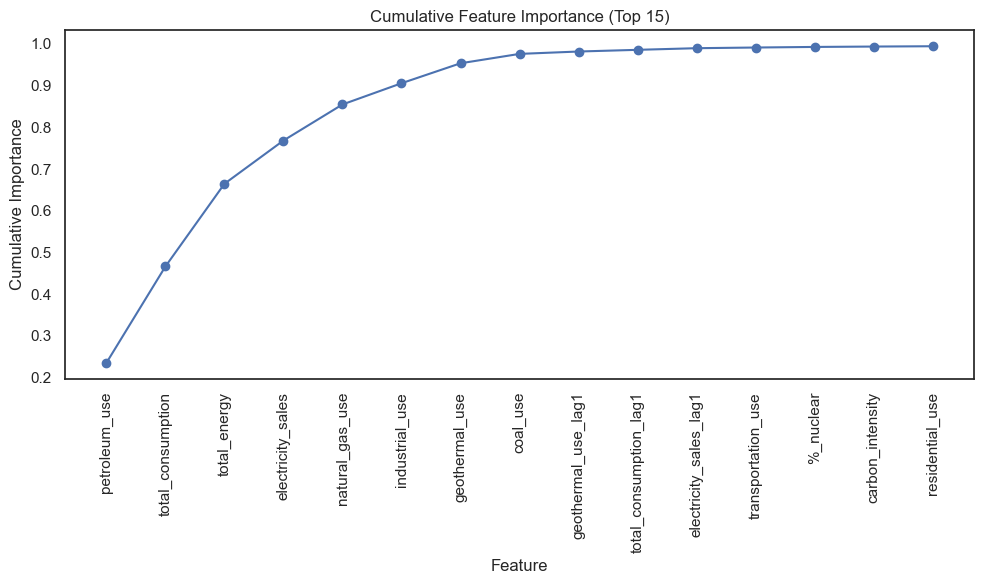

In [36]:
# Plotting cumulative feature importances
# Take top 15 features
top15 = (
    importances
        .sort_values(by='Importance', ascending=False)
        .head(15)
        .reset_index(drop=True)
)

# Compute cumulative importance
top15['Cumulative'] = top15['Importance'].cumsum()

# Plot cumulative importance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(top15['Feature'], top15['Cumulative'], marker='o')

plt.xticks(rotation=90)
plt.xlabel("Feature")
plt.ylabel("Cumulative Importance")
plt.title("Cumulative Feature Importance (Top 15)")

plt.tight_layout()
plt.show()

### Now we will attempt to reduce multicollinearity by dropping one feature of each highly correlated pair (from the top 25 most important features), then only use the remaining features

In [37]:
# Get top 25 most important features
top_features = importances.head(25)['Feature'].tolist()

# Compute correlation matrix among them
corr_matrix = X_train[top_features].corr().abs()

# Identify highly correlated pairs and drop one of each
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
print(f"Identified {len(to_drop)} highly correlated features from the top 25: {to_drop} \n")

Identified 15 highly correlated features from the top 25: ['total_consumption', 'total_energy', 'electricity_sales', 'natural_gas_use', 'industrial_use', 'geothermal_use_lag1', 'total_consumption_lag1', 'electricity_sales_lag1', 'transportation_use', 'residential_use', 'carbon_intensity_lag1', 'petroleum_use_lag1', 'real_gdp', 'coal_use_lag1', 'population'] 



In [38]:
# Retrain XGBoost model on top 25 most important features
selected_X = X_train[top_features]
selected_X_test = X_test[top_features]
xgb2, results_df2 = perform_grid_search(selected_X, y_train)

results_df2

The best parameter combination is {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}
MSE of best GridSearchCV model: -22.262441450614176


,params,mean_test_score,std_test_score,rank_test_score
15,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",-22.262441,5.709978,1
63,"{'colsample_bytree': 1, 'learning_rate': 0.2, ...",-23.802314,4.776678,2
51,"{'colsample_bytree': 1, 'learning_rate': 0.1, ...",-24.063023,5.182230,3
27,"{'colsample_bytree': 0.8, 'learning_rate': 0.2...",-24.273841,6.281154,4
35,"{'colsample_bytree': 0.8, 'learning_rate': 0.2...",-24.701903,5.447022,5
...,...,...,...,...
40,"{'colsample_bytree': 1, 'learning_rate': 0.01,...",-1958.056460,484.388230,68
37,"{'colsample_bytree': 1, 'learning_rate': 0.01,...",-2018.388278,373.049237,69
1,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",-2026.776986,368.011088,70
36,"{'colsample_bytree': 1, 'learning_rate': 0.01,...",-2076.305875,470.154638,71


In [39]:
# Retrain XGBoost model on top 25 most important features
selected_X = X_train[top_features]
xgb2, results_df2 = perform_grid_search(selected_X, y_train)

results_df2

The best parameter combination is {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}
MSE of best GridSearchCV model: -22.262441450614176


,params,mean_test_score,std_test_score,rank_test_score
15,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",-22.262441,5.709978,1
63,"{'colsample_bytree': 1, 'learning_rate': 0.2, ...",-23.802314,4.776678,2
51,"{'colsample_bytree': 1, 'learning_rate': 0.1, ...",-24.063023,5.182230,3
27,"{'colsample_bytree': 0.8, 'learning_rate': 0.2...",-24.273841,6.281154,4
35,"{'colsample_bytree': 0.8, 'learning_rate': 0.2...",-24.701903,5.447022,5
...,...,...,...,...
40,"{'colsample_bytree': 1, 'learning_rate': 0.01,...",-1958.056460,484.388230,68
37,"{'colsample_bytree': 1, 'learning_rate': 0.01,...",-2018.388278,373.049237,69
1,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",-2026.776986,368.011088,70
36,"{'colsample_bytree': 1, 'learning_rate': 0.01,...",-2076.305875,470.154638,71


This led to a small improvement in the model, suggesting that by only using the most informative features, we are able to generate better predictions because we are supplying our model with less noise.

### Here we are trying to reduce multicollinearity by considering all features, then dropping 1 feature from each highly correlated pair.

In [40]:
# Identify highly correlated pairs and drop one of each
# this is attempting to drop one feature from each highly correlated pair
upper = X_train.corr().where(np.triu(np.ones(X_train.corr().shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

# Filter X_train data to exclude multi-collinearity
print(f"Identified {len(to_drop)} highly correlated features out of {X_train.shape[1]} total features: {to_drop}\n")
X_uncorrelated = X_train.drop(to_drop, axis = 'columns')
X_uncorrelated_test = X_test.drop(to_drop, axis = 'columns')

xgb3, results_df3 = perform_grid_search(X_uncorrelated, y_train)

Identified 28 highly correlated features out of 47 total features: ['natural_gas_use', 'petroleum_use', 'biomass_use', 'residential_use', 'commercial_use', 'industrial_use', 'transportation_use', 'total_consumption', 'real_gdp', 'population', 'total_energy', '%_coal', '%_hydro', 'coal_use_lag1', 'natural_gas_use_lag1', 'petroleum_use_lag1', 'nuclear_use_lag1', 'renewables_use_lag1', 'biomass_use_lag1', 'geothermal_use_lag1', 'hydro_use_lag1', 'solar_use_lag1', 'wind_use_lag1', 'real_gdp_lag1', 'carbon_intensity_lag1', 'electricity_sales_lag1', 'total_consumption_lag1', 'rps_lag2']

The best parameter combination is {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
MSE of best GridSearchCV model: -78.00790747123823


This made the MSE EVEN WORSE. There are too many features being removed when dropping one feature from each correlated pair. Because XGBoost is resilient to correlated features and because our MSE is better when keeping all features in the model, maintaining all 36 numerical features may be the best option. 

### What if we train the model on the dataset that excludes the energy % columns (as it is clear they all have a low correlation with the target)?

In [41]:
xgb4, results_df4 = perform_grid_search(mini_X_train, y_train)
results_df4.head()

The best parameter combination is {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
MSE of best GridSearchCV model: -36.845261539331354


,params,mean_test_score,std_test_score,rank_test_score
14,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",-36.845262,6.626911,1
63,"{'colsample_bytree': 1, 'learning_rate': 0.2, ...",-37.359978,6.275888,2
61,"{'colsample_bytree': 1, 'learning_rate': 0.2, ...",-39.004820,6.022133,3
51,"{'colsample_bytree': 1, 'learning_rate': 0.1, ...",-39.629786,9.968568,4
15,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",-40.196039,11.868493,5


In [42]:
# Testing on XGBoost models
selected_X_test = X_test[top_features]
X_uncorrelated_test = X_test.drop(to_drop, axis = 'columns')

# Predictions
y_pred1 = xgb1.predict(X_test)
y_pred2 = xgb2.predict(selected_X_test)
y_pred3 = xgb3.predict(X_uncorrelated_test)
y_pred4 = xgb4.predict(mini_X_test)

# Helper function for metrics
def compute_metrics(y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return mse, rmse, mae, r2

# Compute metrics for each model
m1 = compute_metrics(y_test, y_pred1)
m2 = compute_metrics(y_test, y_pred2)
m3 = compute_metrics(y_test, y_pred3)
m4 = compute_metrics(y_test, y_pred4)

# Build Metrics DataFrame
metrics_df = pd.DataFrame({
    "Model": ["Full XGB (incl %)", "Top 25 Features XGB (From full df)", "Uncorrelated Features XGB (From full df)", "Mini Feature XGB (No %)"],
    "MSE":   [m1[0], m2[0], m3[0], m4[0]],
    "RMSE":  [m1[1], m2[1], m3[1], m4[1]],
    "MAE":   [m1[2], m2[2], m3[2], m4[2]],
    "R2":    [m1[3], m2[3], m3[3], m4[3]]
})

metrics_df

,Model,MSE,RMSE,MAE,R2
0,Full XGB (incl %),14.493875,3.807082,2.482009,0.998702
1,Top 25 Features XGB (From full df),13.325801,3.650452,2.500461,0.998806
2,Uncorrelated Features XGB (From full df),30.842883,5.553637,3.875535,0.997237
3,Mini Feature XGB (No %),11.781830,3.432467,2.387682,0.998945


Based on this analysis, the best XGBoost model is the one that was trained on all features, except the energy % column. Our test R^2 of 0.998 implies that 99.8% of the variance in the target variable can be explained by the predictors when using our features to generate predictions on unseen data. The test RMSE of 3.43 means that, on average, the model’s predictions are about 3.43 units away from the true values. In our case, this means that the model is off by ~3.43 tons on average for each prediction. We can put that value into scale by considering the relative root mean squared error, or rather the RMSE as a percentage of the mean of the target.

In [43]:
# Compute mean of actual target
y_mean = np.mean(y_test)

# Compute RMSE as a percentage of the mean
rmse_percent = (metrics_df.loc[3, "RMSE"] / y_mean) * 100

print(f"Test RMSE as % of mean: {rmse_percent:.2f}%")

Test RMSE as % of mean: 3.31%


The model's typical error is ~3.31% of the average target value. 

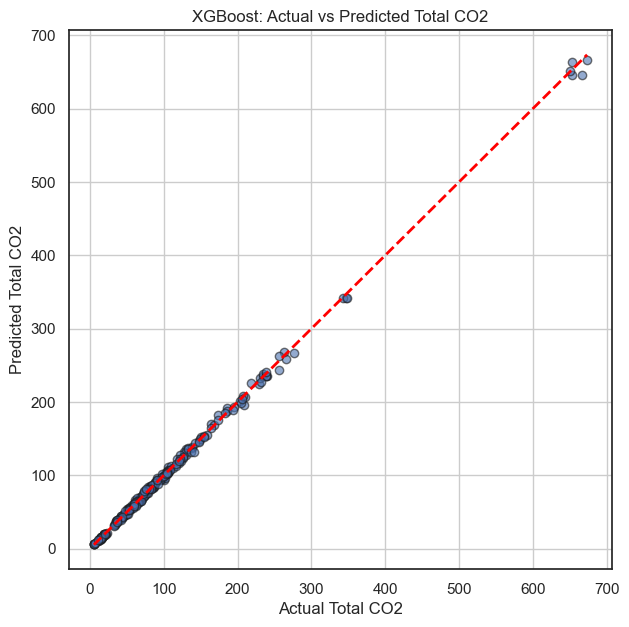

In [44]:
# Visualizing the predictions

# Scatter plot: Actual vs Predicted
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred4, alpha=0.6, edgecolor='k')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', linestyle='--', linewidth=2)
plt.xlabel("Actual Total CO2")
plt.ylabel("Predicted Total CO2")
plt.title("XGBoost: Actual vs Predicted Total CO2")
plt.grid(True)
plt.show()

In [45]:
# Saving the most optimal model
xgb4.save_model("xgboost_model.json")